In [1]:
import itertools
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import anndata
from scipy.cluster import hierarchy as sch

import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
import seaborn as sns

from dredFISH.Utils import basicu
from dredFISH.Utils import powerplots

In [2]:
def get_normed_bulks(mat, genes, types, genes_sel_idx=None):
    """
    Assume cell by gene
    - select expressed genes
    - sparse to dense
    - merge cells to clusters
    - log10(CPM+1) norm bulk samples
    """
    ncell, ngene = mat.shape
    cellcov = np.asarray(mat.sum(axis=1)).reshape(-1,)
    genecov = np.asarray(mat.sum(axis=0)).reshape(-1,)
    
    if genes_sel_idx is None:
        cond = genecov>ncell*0.01 # expressed in at least 1% of cells
        matsub = np.asarray(mat[:,cond].todense())
        genes_sel = genes[cond]
    else:
        matsub = np.asarray(mat[:,genes_sel_idx].todense())
        genes_sel = genes[genes_sel_idx]
    
    # pseudo-bulk samples -- pull counts from cells
    Xk, xclsts = basicu.group_sum(matsub, types)
    ck, xclsts = basicu.group_sum(cellcov.reshape(-1,1), types)
    Xk = np.log10(1+(np.array(Xk)/np.array(ck))*1e6) # log10(1+CPM)
    df = pd.DataFrame(Xk, index=xclsts, columns=genes_sel)
    return df.T # gene by types 

def get_normed_bulks_for_adata_by_types(adata, genes_cndd=None):
    """
    """
    if genes_cndd is None:
        genes_sel_idx = None
    else:
        genes_sel_idx = basicu.get_index_from_array(adata.var.index.values, genes_cndd)
        if np.sum(genes_sel_idx == -1) > 0:
            print("some genes are not there")
            genes_sel_idx = genes_sel_idx[genes_sel_idx!=-1]
            
    return get_normed_bulks(adata.X.copy(), adata.var.index.values, adata.obs['Type'], 
                            genes_sel_idx=genes_sel_idx)

In [3]:
sns.set_context('talk')

In [4]:
cnddts = [
    'Hsd11b1',
    'Endou',
    'Whrn',
    'Tox2',
    'Batf3',
    'Col6a1',
    'Fezf2',
    'Col27a1',
]

In [5]:
# f = "/greendata/GeneralStorage/fangming/projects/visctx/data_dump/MERFISH_gene_panel_ver_3-2_Feb2023.csv"
# df_merfish = pd.read_csv(f)

# # # df_merfish = df_merfish[~df_merfish[0].isnull()]
# cnddts = df_merfish['gene_name_data'].values
# unq, cnts = np.unique(cnddts, return_counts=True)
# print(len(cnddts), unq.shape, unq[cnts>1])

# df_merfish

In [6]:
f = '../data_dump/counts/P28_nr_allcells_Oct24.h5ad'
adata_nr = anndata.read(f)
f = '../data_dump/counts/P28_dr_allcells_Oct25.h5ad'
adata_dr = anndata.read(f)

genes_data = adata_nr.var.index.values

adata_nr, adata_dr, genes_data

/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


(AnnData object with n_obs × n_vars = 23930 × 53547
     obs: 'cov', 'covfactor', 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'Class_broad', 'sample', 'Type', 'Subclass'
     var: 'id',
 AnnData object with n_obs × n_vars = 24816 × 53547
     obs: 'cov', 'covfactor', 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample', 'Type', 'Subclass'
     var: 'id',
 array(['4933401J01Rik', 'Gm26206', 'Xkr4', ..., 'CAAA01064564.1',
        'Vmn2r122', 'CAAA01147332.1'], dtype=object))

In [7]:
gunsel = [g for g in cnddts if g not in genes_data]
len(gunsel), gunsel

(0, [])

In [8]:
genes_cndd = np.array([g for g in cnddts if g in genes_data])
len(genes_cndd)

8

In [9]:
nr_types = np.sort(adata_nr.obs['Type'].unique().astype(str))
dr_types = np.sort(adata_dr.obs['Type'].unique().astype(str))
nr_types, dr_types

(array(['Astro_A', 'Astro_B', 'Endo', 'Frem1', 'L2/3_A', 'L2/3_B',
        'L2/3_C', 'L4_A', 'L4_B', 'L4_C', 'L5IT', 'L5NP', 'L5PT_A',
        'L5PT_B', 'L6CT_A', 'L6CT_B', 'L6CT_C', 'L6IT_A', 'L6IT_B', 'L6b',
        'Lamp5', 'Micro', 'OD_A', 'OD_B', 'OD_C', 'OPC_A', 'OPC_B',
        'Pvalb_A', 'Pvalb_B', 'Pvalb_C', 'Pvalb_D', 'Sst_A', 'Sst_B',
        'Sst_C', 'Sst_D', 'Sst_E', 'Stac', 'VLMC_A', 'VLMC_B', 'Vip_A',
        'Vip_B', 'Vip_C'], dtype='<U7'),
 array(['Astro_A', 'Astro_B', 'Endo', 'Frem1', 'L2/3_1', 'L2/3_2',
        'L2/3_3', 'L4_1', 'L4_2', 'L4_C', 'L5IT', 'L5NP', 'L5PT_A',
        'L5PT_B', 'L6CT_A', 'L6CT_B', 'L6CT_C', 'L6IT_A', 'L6IT_B', 'L6b',
        'Lamp5', 'Micro', 'OD_A', 'OD_B', 'OD_C', 'OPC_A', 'OPC_B',
        'Pvalb_A', 'Pvalb_B', 'Pvalb_C', 'Pvalb_D', 'Sst_A', 'Sst_B',
        'Sst_C', 'Sst_D', 'Sst_E', 'Stac', 'VLMC_A', 'VLMC_B', 'Vip_A',
        'Vip_B', 'Vip_C'], dtype='<U7'))

In [10]:
adata_nr.obs['biosample'] = adata_nr.obs['sample'].apply(lambda x: x[:-1])
adata_dr.obs['biosample'] = adata_dr.obs['sample'].apply(lambda x: x[:-1])
samples_nr = np.unique(adata_nr.obs['biosample'])
samples_dr = np.unique(adata_dr.obs['biosample'])
samples_nr, samples_dr

(array(['P28_1', 'P28_2'], dtype=object),
 array(['P28_dr_1', 'P28_dr_3'], dtype=object))

In [11]:
adatasub_nr = adata_nr[adata_nr.obs['Type']=='L5IT', cnddts]
adatasub_dr = adata_dr[adata_dr.obs['Type']=='L5IT', cnddts]

In [12]:
adatasub_nr

View of AnnData object with n_obs × n_vars = 849 × 8
    obs: 'cov', 'covfactor', 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'Class_broad', 'sample', 'Type', 'Subclass', 'biosample'
    var: 'id'

In [13]:
%%time
dfs_nr = []
for samp in samples_nr:
    adatasub = adata_nr[adata_nr.obs['biosample']==samp]
    df = get_normed_bulks_for_adata_by_types(adatasub, genes_cndd=genes_cndd)
    print(df.shape)
    print(df.columns)
    dfs_nr.append(df)

dfs_dr = []
for samp in samples_dr:
    adatasub = adata_dr[adata_dr.obs['biosample']==samp]
    df = get_normed_bulks_for_adata_by_types(adatasub, genes_cndd=genes_cndd)
    print(df.shape)
    print(df.columns)
    dfs_dr.append(df)
    
tensor_nr = np.stack(dfs_nr, axis=2)
tensor_dr = np.stack(dfs_dr, axis=2)
tensor_nr.shape, tensor_dr.shape

(8, 42)
Index(['Astro_A', 'Astro_B', 'Endo', 'Frem1', 'L2/3_A', 'L2/3_B', 'L2/3_C',
       'L4_A', 'L4_B', 'L4_C', 'L5IT', 'L5NP', 'L5PT_A', 'L5PT_B', 'L6CT_A',
       'L6CT_B', 'L6CT_C', 'L6IT_A', 'L6IT_B', 'L6b', 'Lamp5', 'Micro', 'OD_A',
       'OD_B', 'OD_C', 'OPC_A', 'OPC_B', 'Pvalb_A', 'Pvalb_B', 'Pvalb_C',
       'Pvalb_D', 'Sst_A', 'Sst_B', 'Sst_C', 'Sst_D', 'Sst_E', 'Stac',
       'VLMC_A', 'VLMC_B', 'Vip_A', 'Vip_B', 'Vip_C'],
      dtype='object')
(8, 42)
Index(['Astro_A', 'Astro_B', 'Endo', 'Frem1', 'L2/3_A', 'L2/3_B', 'L2/3_C',
       'L4_A', 'L4_B', 'L4_C', 'L5IT', 'L5NP', 'L5PT_A', 'L5PT_B', 'L6CT_A',
       'L6CT_B', 'L6CT_C', 'L6IT_A', 'L6IT_B', 'L6b', 'Lamp5', 'Micro', 'OD_A',
       'OD_B', 'OD_C', 'OPC_A', 'OPC_B', 'Pvalb_A', 'Pvalb_B', 'Pvalb_C',
       'Pvalb_D', 'Sst_A', 'Sst_B', 'Sst_C', 'Sst_D', 'Sst_E', 'Stac',
       'VLMC_A', 'VLMC_B', 'Vip_A', 'Vip_B', 'Vip_C'],
      dtype='object')
(8, 42)
Index(['Astro_A', 'Astro_B', 'Endo', 'Frem1', 'L2/3_1', 'L2/3_2', 

((8, 42, 2), (8, 42, 2))

# visualize
### cell levels

In [14]:
def get_lcpm_and_corder(adata):
    """
    """
    
    cmat = np.asarray(adata.X.todense())
    cov  = adata.obs['n_counts'].values
    lcpm  = np.log10(1+cmat/cov.reshape(-1,1)*1e6)
    corder = sch.dendrogram(sch.linkage(lcpm, method='average'), no_plot=True)['leaves'] #['']
    
    return lcpm, corder 

def get_roworder(ftrs):
    """
    """
    roworder = sch.dendrogram(sch.linkage(ftrs, method='average'), no_plot=True)['leaves'] #['']
    return roworder
    

In [15]:
genes = adatasub_nr.var.index.values
lcpm_nr, cord_nr = get_lcpm_and_corder(adatasub_nr)
lcpm_dr, cord_dr = get_lcpm_and_corder(adatasub_dr)

In [16]:
lcpm_nrdr = np.vstack([lcpm_nr, lcpm_dr])
cord_nrdr = get_roworder(lcpm_nrdr)
clbl_nrdr = np.hstack([[0]*len(lcpm_nr), 
                       [1]*len(lcpm_dr),
                      ])

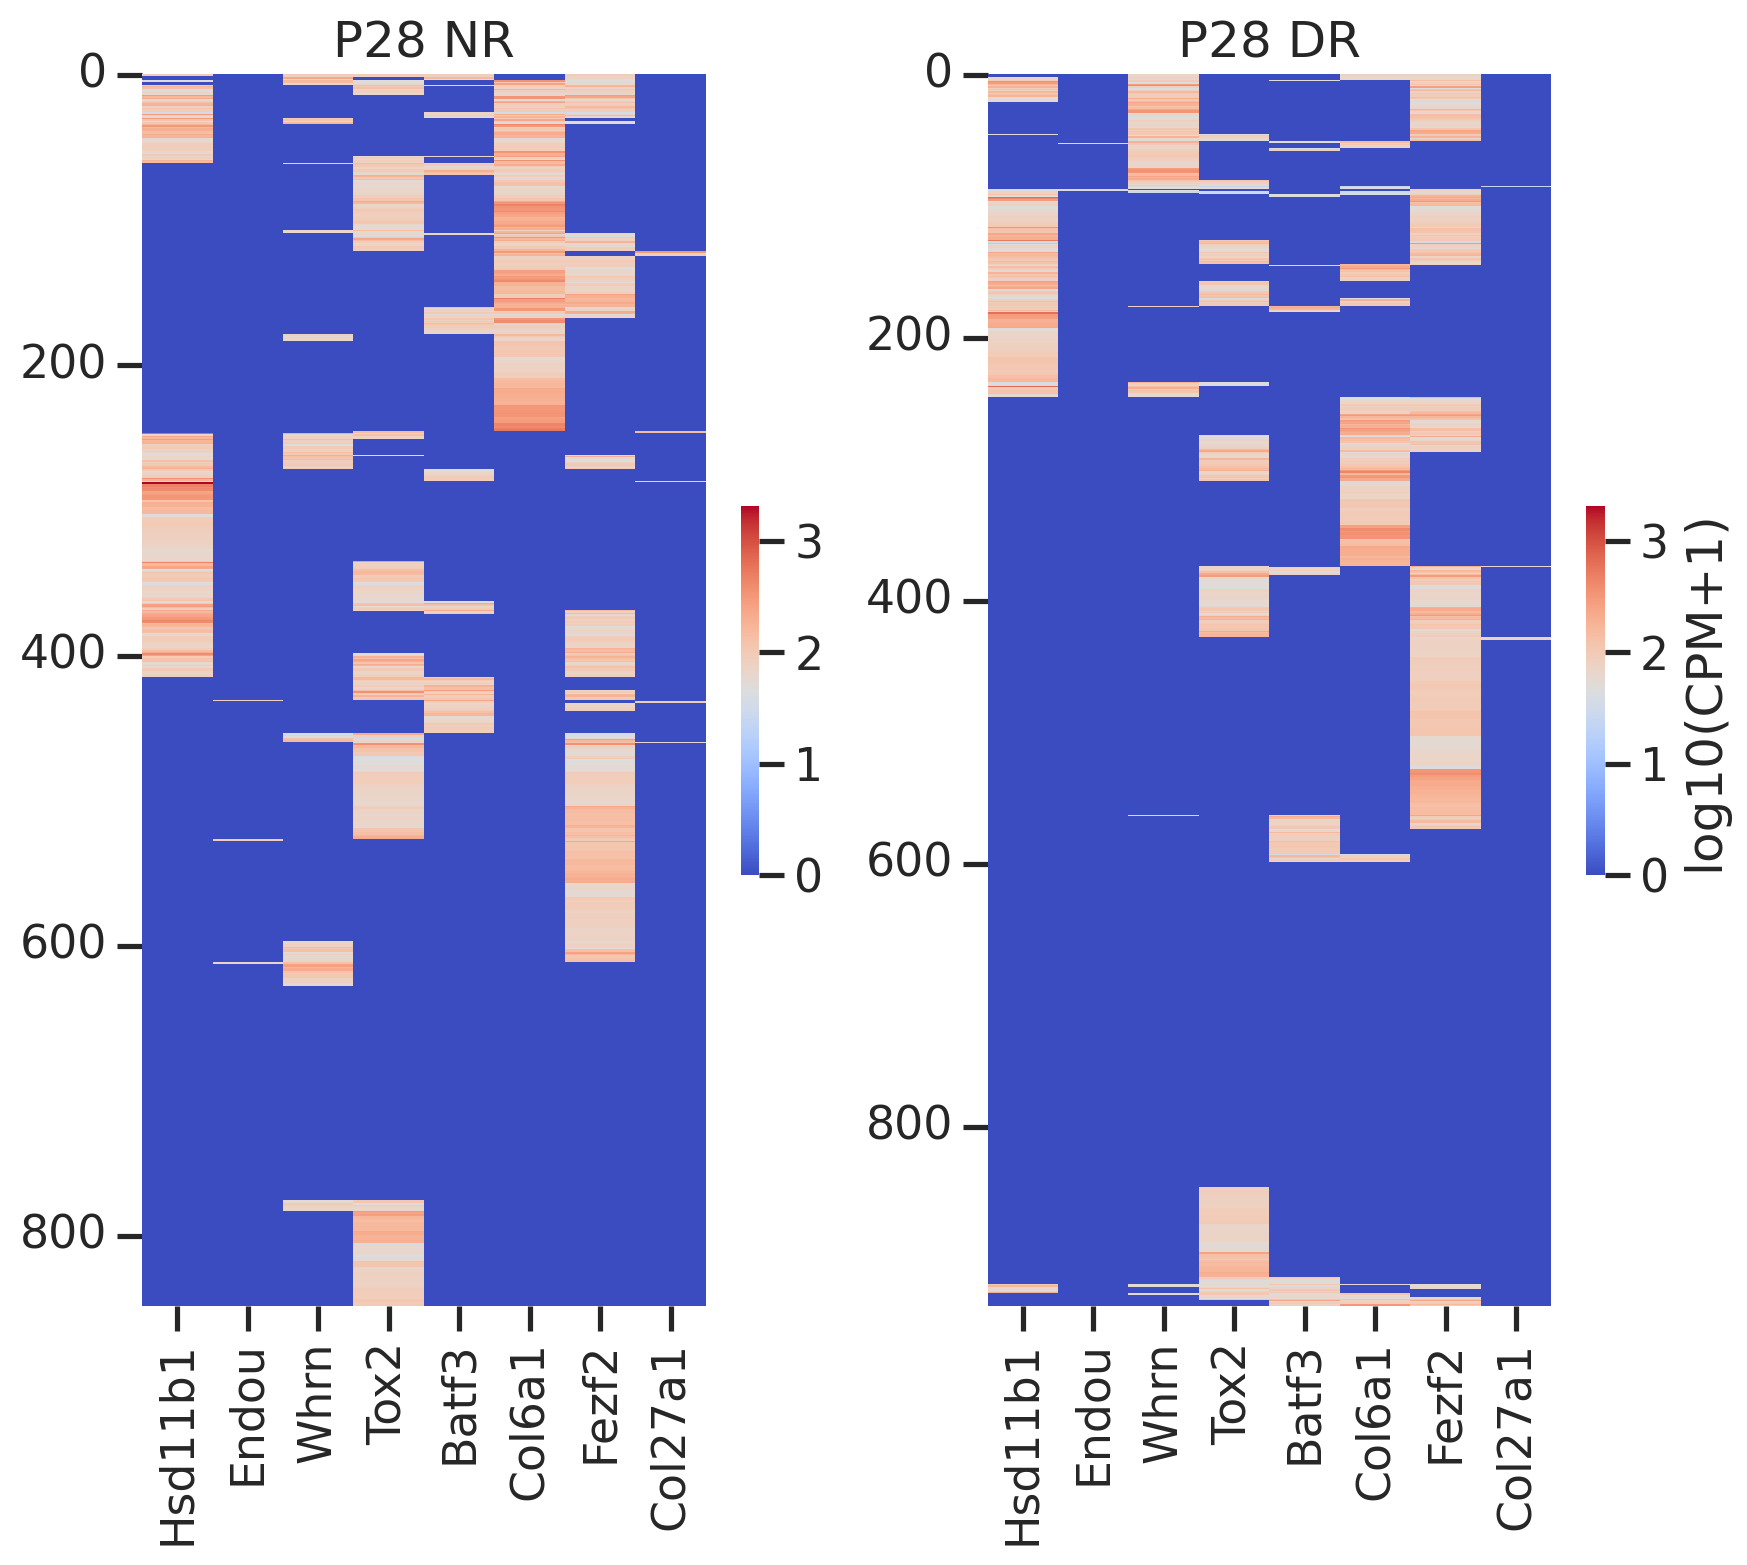

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(5*2,8))
vmax = max(np.max(lcpm_nr), np.max(lcpm_dr))
ax = axs[0]
sns.heatmap(lcpm_nr[cord_nr],#[:,gorder], 
            yticklabels=200,
            xticklabels=genes,
            cbar_kws=dict(shrink=0.3, label=''),
            cmap='coolwarm',
            vmax=vmax,
            ax=ax
           )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title('P28 NR')

ax = axs[1]
sns.heatmap(lcpm_dr[cord_dr],#[:,gorder], 
            yticklabels=200,
            xticklabels=genes,
            cbar_kws=dict(shrink=0.3, label='log10(CPM+1)'),
            cmap='coolwarm',
            vmax=vmax,
            ax=ax
           )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title('P28 DR')
plt.show()

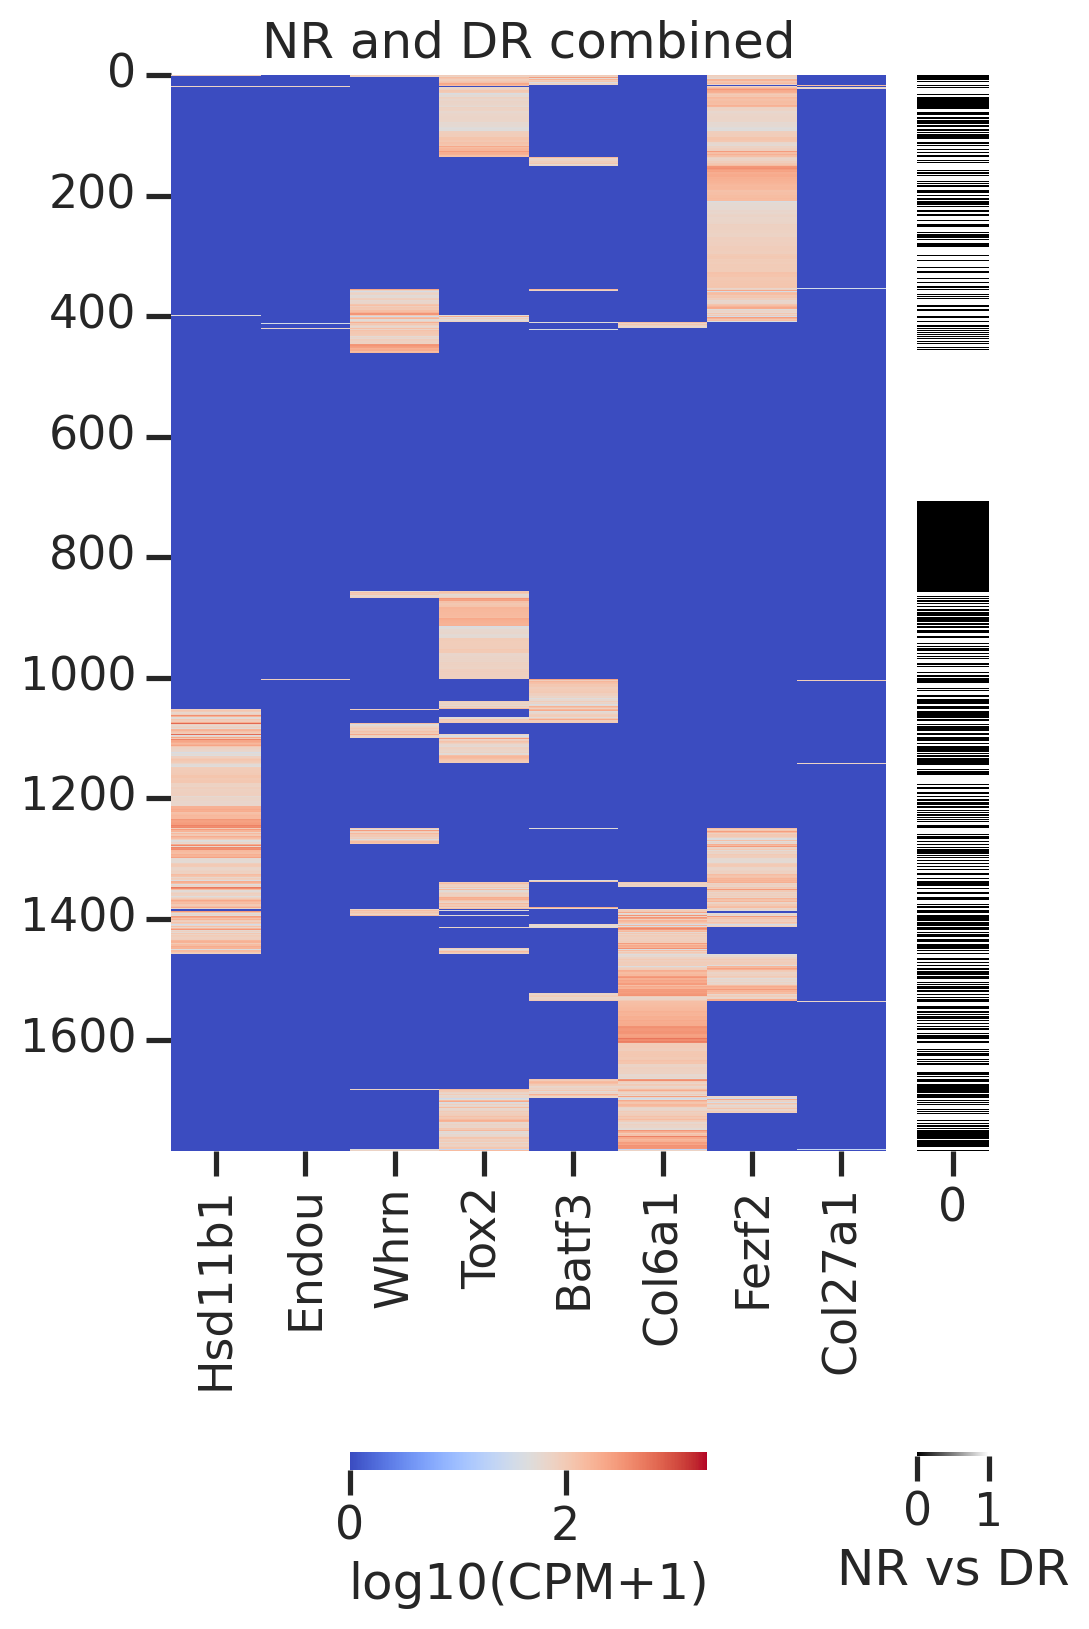

In [18]:
fig, axs = plt.subplot_mosaic([['a']*10+['b'],],
                              constrained_layout=True, 
                              figsize=(5,8),
                             )
ax = axs['a']
sns.heatmap(lcpm_nrdr[cord_nrdr],#[:,gorder], 
            yticklabels=200,
            xticklabels=genes,
            cbar_kws=dict(shrink=0.5, location='bottom', label='log10(CPM+1)'),
            cmap='coolwarm',
            ax=ax
           )
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title('NR and DR combined')

ax = axs['b']
sns.heatmap(clbl_nrdr.reshape(-1,1)[cord_nrdr],#[:,gorder], 
            yticklabels=False,
            cbar_kws=dict(shrink=1, location='bottom', label='NR vs DR'),
            # cbar_kws=False,
            cmap='gray',
            ax=ax
           )
plt.show()

# positive vs negative for each gene by samples and conditions